# Dynamical Systems Theory in machine learning: Final Project

Author: Fabian Kontor<br>
ID: 4013130

In this project, we looked at different approaches to model the dynamical systems known as Lorenz63 and Lorenz96. In the end, we decided to use the approach from [Rusch et al.](https://openreview.net/forum?id=vwj6aUeocyf) called Long Expressive Memory (LEM). Reasons include the good documentation, ease of implementation and managable training times. The summary of this paper and approach can be found in *summary/LEM_summary.pdf*. We also considered other approaches like [Transformers](https://github.com/KasperGroesLudvigsen/influenza_transformer) due to their current popularity, but decided against them due to the lack of documentation and the high training times. We also considered the approach of [Next Generation Reservoir Computing](https://www.nature.com/articles/s41467-021-25801-2), which was very fast when it comes to training, however the documentation here was also lacking.

The original repo can be found at: https://github.com/tk-rusch/LEM

# Test model by using FitzHugh-Nagumo example

## Inference

Thankfully, the LEM approach has a lot of [examples](https://github.com/tk-rusch/LEM#experiments). We found the FitzHugh-Nagumo example to be the most relevant one, since its also about modelling a dynamical system. We first tested this example to see if the model could reconstruct the underlying dynamics successfully. The code for this can be found in *LEM_cuda/example/FitzHughNagumo_task.py*. Like for the LSTM and GRU models, inference is done by running a given sequence through the model, which predicts only the next step. We then reuse this prediction in the model to predict the next step and so on. This is done for the whole sequence. The results can be seen in the following figure:

(10, 128, 1)
Progress: 0/872
Progress: 50/872
Progress: 100/872
Progress: 150/872
Progress: 200/872
Progress: 250/872
Progress: 300/872
Progress: 350/872
Progress: 400/872
Progress: 450/872
Progress: 500/872
Progress: 550/872
Progress: 600/872
Progress: 650/872
Progress: 700/872
Progress: 750/872
Progress: 800/872
Progress: 850/872
torch.Size([872, 10, 1])


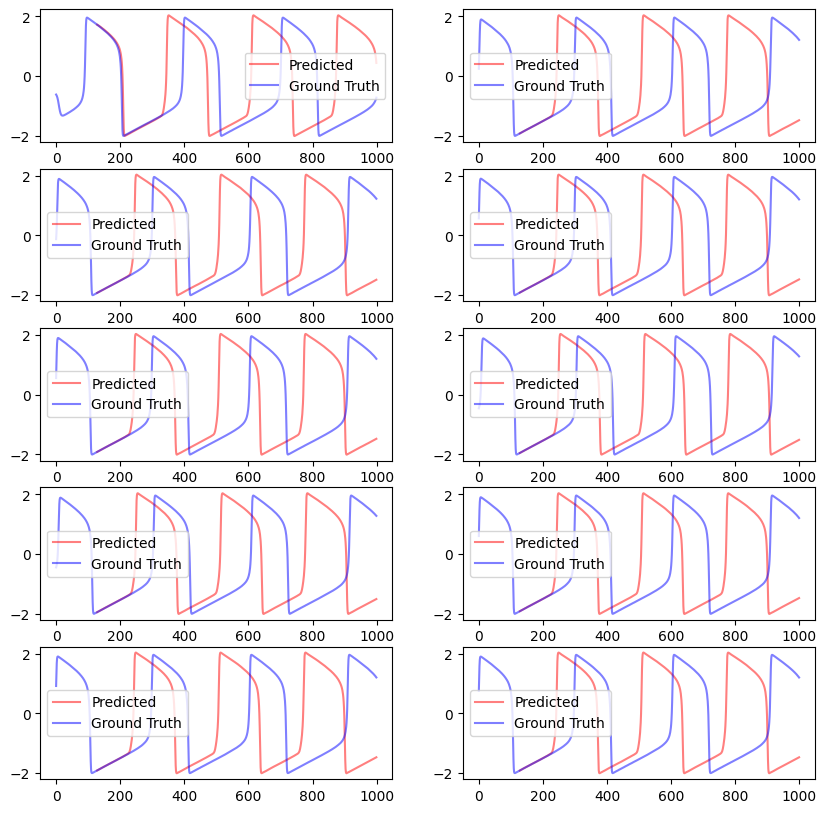

In [68]:
import sys
sys.path.append('src/FitzHughNagumo')
import torch
import network
from data import get_data
from inference import inference, prep, to_numpy
from matplotlib import pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nhid = 16
ninp = 1
nout = 1

model = network.LEM(ninp, nhid, nout).to(device)
model.load_state_dict(torch.load('src/FitzHughNagumo/result/FitzHughNagumo_model2.pt'))


data = get_data(10)
x0 = data[0][:, :128, :]

# A sequence length of 128 is arbitrarily chosen
T_start = 128
T_pred = 1000-128

gt = data[0][:,:T_start+T_pred,:]
x = data[0][:,:T_start,:]
y = inference(model, prep(x).to(device), T_pred)
print(y.shape)

fig, axs = plt.subplots(5, 2, figsize=(10, 10))
for i in range(10):
	axs[i//2, i%2].plot(T_start+np.arange(0, T_pred), to_numpy(y)[:, i, :].reshape(-1), label='Predicted', color='red', alpha=0.5)
	axs[i//2, i%2].plot(np.arange(0, T_start+T_pred), gt[i, :, :].reshape(-1), label='Ground Truth', color='blue', alpha=0.5)
	axs[i//2, i%2].legend()

(10, 256, 1)
Progress: 0/744
Progress: 50/744
Progress: 100/744
Progress: 150/744
Progress: 200/744
Progress: 250/744
Progress: 300/744
Progress: 350/744
Progress: 400/744
Progress: 450/744
Progress: 500/744
Progress: 550/744
Progress: 600/744
Progress: 650/744
Progress: 700/744
torch.Size([744, 10, 1])


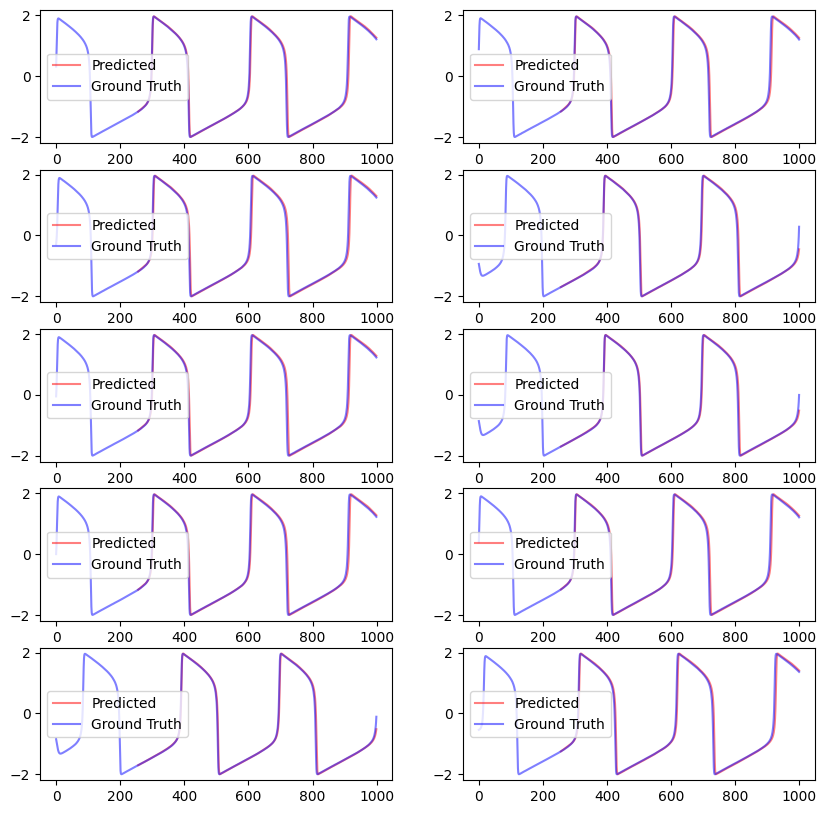

In [263]:
# Redo with sequence length of 256
x0 = data[0][:, :256, :]

T_start = 256
T_pred = 1000-256

gt = data[0][:,:T_start+T_pred,:]
x = data[0][:,:T_start,:]
y = inference(model, prep(x).to(device), T_pred)
print(y.shape)

fig, axs = plt.subplots(5, 2, figsize=(10, 10))
for i in range(10):
	axs[i//2, i%2].plot(T_start+np.arange(0, T_pred), to_numpy(y)[:, i, :].reshape(-1), label='Predicted', color='red', alpha=0.5)
	axs[i//2, i%2].plot(np.arange(0, T_start+T_pred), gt[i, :, :].reshape(-1), label='Ground Truth', color='blue', alpha=0.5)
	axs[i//2, i%2].legend()

We find that if we increase the number of GT samples fed to the model and with that the sequence length that the LEM model works uses for prediction, the inference becomes more accurate. If the model was optimal and learned the underlying dynamics successfully, it could do so given only a sequence length of 1 (with an assumption of $\Delta t$). This is the because în these dynamical systems, the next state is always only dependent on the current one. The reason for this need for long sequences might be that the model was trained on a sequence length of 1000. For the Lorenz systems, we try to find a good trade-off between having as low as possible sequence length for the model while having as low as possible MSE. Having a low sequence length also decreases inference time.

# Lorenz63 System

## Training on the Lorenz system

The training as well as running the trained model is not done in this notebook. This is because we cannot run the CUDA version of the LEM in this notebook. Instead, the training is being done in the lorenz_task.py file.
In the notebook, for a sequence length of 1000 with default settings, it takes 66.7 seconds for 10 epochs. Running the LEM cuda version takes 32.5 seconds, which is 2x faster. Note that this varies of course with different settings, however the CUDA version is always faster.

To reduce training times and take advantage of batch processing, we preprocess the data like can be seen in the following cell, to slice it into smaller sequences that can then be batched. To speed up the dataloader, we also add a stride parameter so that we further reduce the number of samples that are loaded into memory. However, to make sure we don't lose any information, we keep the stride equal to or lower than the sequence length.

After training, in addition to the validation loss, we looked at the test loss output to see if it was consistent with a good training (i.e. not overfitting).

We chose a MSE loss with an ADAM optimizer. The learning rate is fixed during each unique training round. But, to try to achieve better convergence, we restart training multiple times with different learning rates and sequence lengths, while reusing the same model. Thus we can fine-tune the model on the fly to try to minimize the sequence length while simultaneously minimizing the MSE.

In [4]:
%run lorenz_task.py \
	--epochs=100 \
	--lr=0.0005 \
	--nhid=50 \
	--seq_len=1 \
	--stride=1 \
	--batch=128 \
	--lorenz_type="lorenz63"

Namespace(batch=128, device=device(type='cuda'), epochs=100, lorenz_type='lorenz63', lr=0.0005, model_path='', nhid=50, seed=1234, seq_len=1, stride=1)
(100000, 3)
Number of train batches: 625
Shape of train batch: [128, 1, 3]
Number of validation batches: 157
Shape of validation batch: [128, 1, 3]
Number of test batches: 782
Shape of test batch: [128, 1, 3]
Training...
Epoch: 001, Val loss: 0.084599
Epoch: 002, Val loss: 0.069813
Epoch: 003, Val loss: 0.074098
Epoch: 004, Val loss: 0.072605
Epoch: 005, Val loss: 0.075244
Epoch: 006, Val loss: 0.054403
Epoch: 007, Val loss: 0.068426
Epoch: 008, Val loss: 0.064484
Epoch: 009, Val loss: 0.075317
Epoch: 010, Val loss: 0.059430
Epoch: 011, Val loss: 0.069162
Epoch: 012, Val loss: 0.073819
Epoch: 013, Val loss: 0.072904
Epoch: 014, Val loss: 0.067705
Epoch: 015, Val loss: 0.064679
Epoch: 016, Val loss: 0.056691
Epoch: 017, Val loss: 0.065850
Epoch: 018, Val loss: 0.069774
Epoch: 019, Val loss: 0.062306
Epoch: 020, Val loss: 0.071494
Epoch: 

Above is a typical training run. We can see that the test loss is significantly lower than the validation loss. This shows that we are not overfitting. It is lower because the test data does not have noise like the training data (the noise increases the MSE). This also indicates that we are doing a good reconstruction of the underlying dynamics despite the fact that we have noisy data.

## Training losses

Note that we worked with multiple training runs on the same model, fine-tuning it by differing parameters like learning rate or sequence length. In the loss plot, the start of each new run is clearly marked and the parameters that changed for that run displayed to the right of it. We try to reduce the sequence length while minimizing MSE.

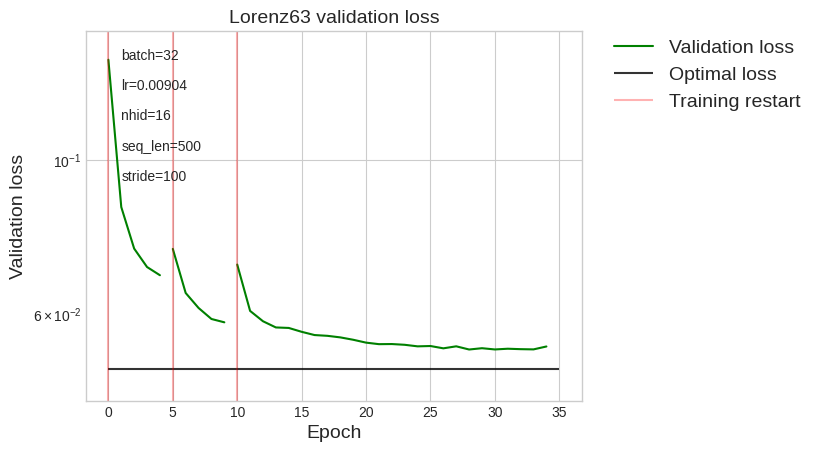

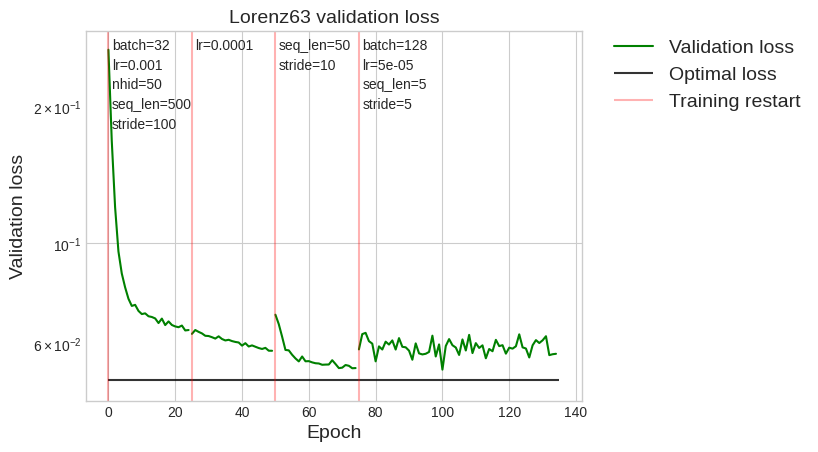

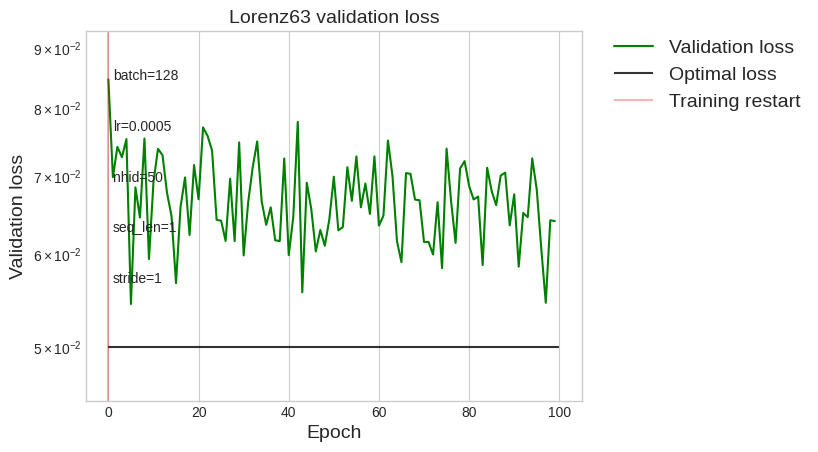

In [5]:
# set theme to cool
import numpy as np
from util import parse_args, load_losses_and_args, plot_training_routine
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

paths = ['models/lorenz63/2/', 'models/lorenz63/3/', 'models/lorenz63/4/']
plot_training_routine(paths, "Lorenz63 validation loss")

paths = ['models/lorenz63/5/', 'models/lorenz63/6/', 'models/lorenz63/7/', 'models/lorenz63/8/']
plot_training_routine(paths, "Lorenz63 validation loss")

paths = ['models/lorenz63/9/']
plot_training_routine(paths, "Lorenz63 validation loss")

In the first plot, we see a very normal training run where we 

In the second plot, we increased the number of hidden states from 16 to 50, however this does not significantly affect the minimum achieved validation loss.

In the third plot, we tried to see if we can get good convergence with a sequence length of only 1. We can clearly see that although the loss lowers at first, the variance of the loss is very high and it does not converge as well as for higher sequence lengths. A good compromise seems to be a sequence length of 5, which gives an ok-ish convergence while still being fast.

Additionally, one notes that the validation loss seems to approach $\approx 0.05$ asymptotically. This is because the training data has observation noise with 5-percent of the data variance added to it. This means that we the best validation loss we can achieve is 0.05 (validation data also has this noise added). To check this, we add noise in the same way to the test data, which doesn't have noise itself and thus represent an optimal reconstruction of the noisy data. We see that the MSE is indeed 0.05. This also applies to the Lorenz96 system.

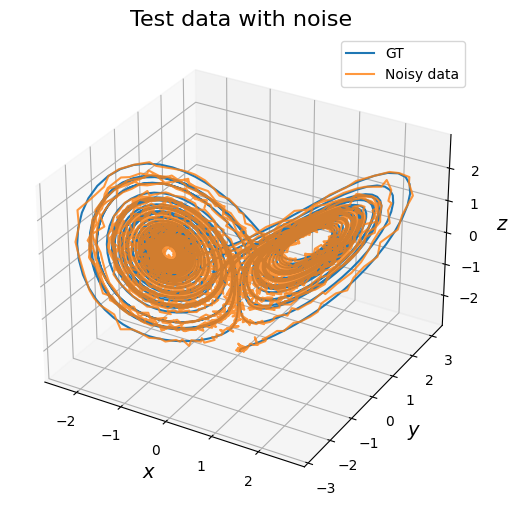

MSE: 0.05000120773911476


In [68]:
import psd
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import torch


test_data = np.load("data/lorenz63_test.npy")
objective = nn.MSELoss()

noisy_data = test_data.copy()
noisy_data += np.random.normal(0, 0.05 * np.var(test_data), noisy_data.shape)

objective = nn.MSELoss()

loss = torch.sqrt(objective(torch.Tensor(test_data), torch.Tensor(noisy_data))).item()

T = 5000

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(test_data[:T,0], test_data[:T,1], test_data[:T,2], label='GT')
ax.plot(noisy_data[:T,0], noisy_data[:T,1], noisy_data[:T,2], label='Noisy data', alpha=0.8)

plt.title('Test data with noise', fontsize=16)
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$y$', fontsize=14)
ax.set_zlabel(r'$z$', fontsize=14)
plt.legend()
plt.show()

print('MSE:', loss)

## Reconstruction and power-spectrum distance

Plotting inferred trajectories is done with the plot.py script. It plots a prediction of the test data against the ground truth, so you can visually compare the performance of the model.

Progress: 0/1000
Progress: 200/1000
Progress: 400/1000
Progress: 600/1000
Progress: 800/1000


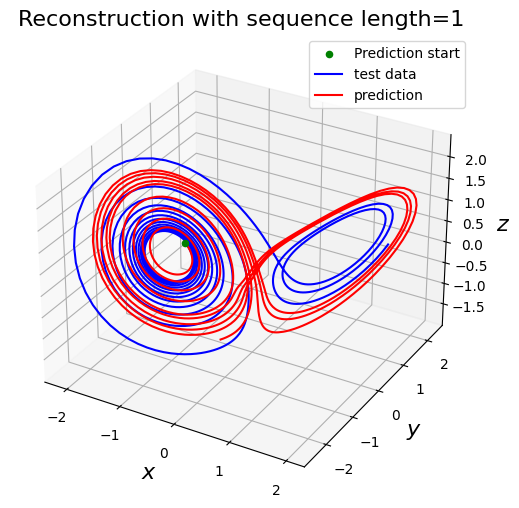

Progress: 0/1000
Progress: 200/1000
Progress: 400/1000
Progress: 600/1000
Progress: 800/1000


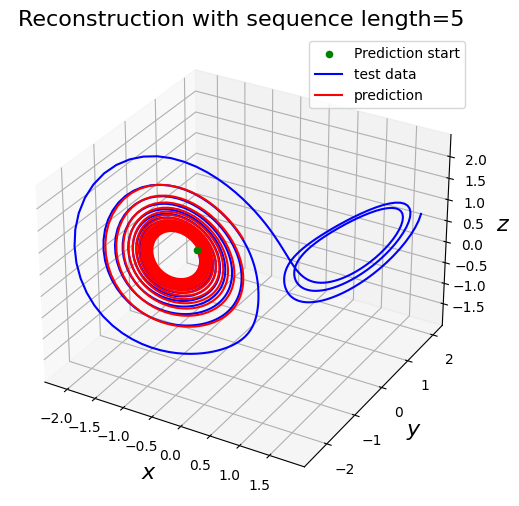

Progress: 0/1000
Progress: 200/1000
Progress: 400/1000
Progress: 600/1000
Progress: 800/1000


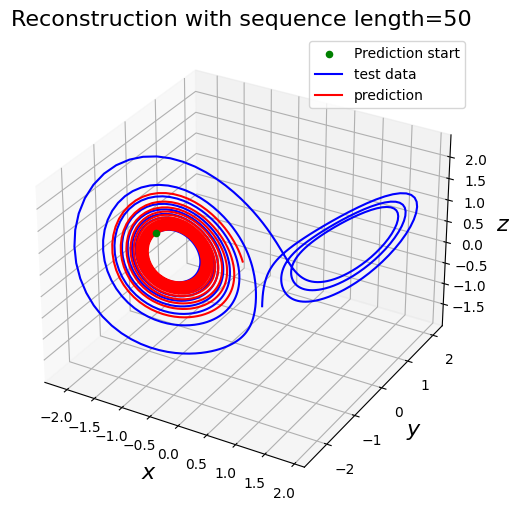

In [1]:
%run plot.py \
	--model_path="models/lorenz63/9/model.pt" \
	--lorenz_type="lorenz63" \
	--nhid=50 \
	--T=1000 \
	--bootstrapT=1 \
	--title="Reconstruction with sequence length=1"

%run plot.py \
	--model_path="models/lorenz63/8/model.pt" \
	--lorenz_type="lorenz63" \
	--nhid=50 \
	--T=1000 \
	--bootstrapT=5 \
	--title="Reconstruction with sequence length=5"

%run plot.py \
	--model_path="models/lorenz63/7/model.pt" \
	--lorenz_type="lorenz63" \
	--nhid=50 \
	--T=1000 \
	--bootstrapT=50 \
	--title="Reconstruction with sequence length=50"

We can see that while the plot for sequence length=1 starts to diverge quickly from the ground truth, it is still able to exhibit dynamics typical to the Lorenz63 system. Using a sequence length=5 seems to give a closer reconstruction of the ground truth, and sequence length=50 still does well but isn't much better than sequence length=5.

Before we compute the power-spectrum distance, we first generate a time series with length equal to the test data length. We do this by drawing a random initial condition and using the model to infer the next state until the sequence has the desired length. We use the model trained on sequence lengths of 5.

Progress: 0/100010
Progress: 50/100010
Progress: 100/100010
Progress: 150/100010
Progress: 200/100010
Progress: 250/100010
Progress: 300/100010
Progress: 350/100010
Progress: 400/100010
Progress: 450/100010
Progress: 500/100010
Progress: 550/100010
Progress: 600/100010
Progress: 650/100010
Progress: 700/100010
Progress: 750/100010
Progress: 800/100010
Progress: 850/100010
Progress: 900/100010
Progress: 950/100010
Progress: 1000/100010
Progress: 1050/100010
Progress: 1100/100010
Progress: 1150/100010
Progress: 1200/100010
Progress: 1250/100010
Progress: 1300/100010
Progress: 1350/100010
Progress: 1400/100010
Progress: 1450/100010
Progress: 1500/100010
Progress: 1550/100010
Progress: 1600/100010
Progress: 1650/100010
Progress: 1700/100010
Progress: 1750/100010
Progress: 1800/100010
Progress: 1850/100010
Progress: 1900/100010
Progress: 1950/100010
Progress: 2000/100010
Progress: 2050/100010
Progress: 2100/100010
Progress: 2150/100010
Progress: 2200/100010
Progress: 2250/100010
Progress: 2

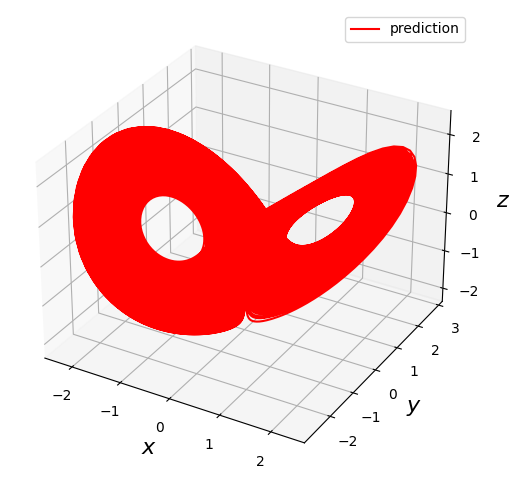

0.5929360491687938


'%run psd_routine.py \t--model_path="models/lorenz63/8/model.pt" \t--nhid=50 \t--T=1000 \t--bootstrapT=100'

In [7]:
%run psd_routine.py \
	--model_path="models/lorenz63/8/model.pt" \
	--nhid=50 \
	--T=100000 \
    --bootstrapT=5

We get a power-spectrum distance of $\approx 0.6$ with $\sigma=20$, which indicates a moderate level of difference between the power spectra of the two time series. We haven't optimized for power-spectrum distance, so this is still a good result. Let's see how the PSD varies given different smoothing parameters $\sigma$.

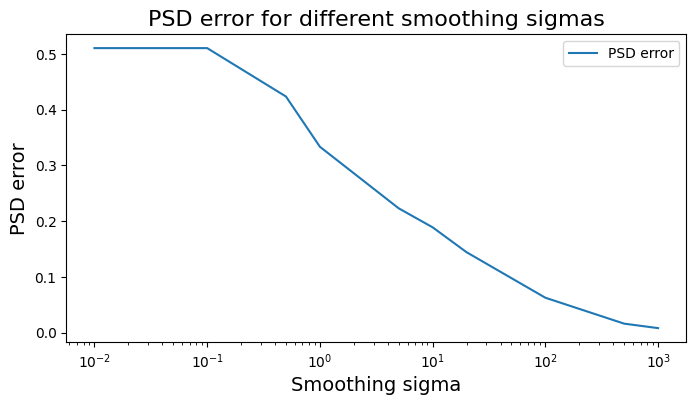

In [7]:
import psd
import numpy as np
import matplotlib.pyplot as plt

test_data = np.load('data/lorenz63_test.npy')
gen_data = np.load('data/lorenz63_gen.npy')

uniform_data = np.random.uniform(-1, 1, gen_data.shape)

sigmas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 100, 500, 1000]
psds = []

for sigma in sigmas:
	psd.SMOOTHING_SIGMA = sigma
	psds.append(psd.power_spectrum_error(test_data.reshape(1, -1, 3), gen_data.reshape(1, -1, 3)))

plt.figure(figsize=(8, 4))
plt.plot(sigmas, psds, label='PSD error')
plt.xlabel('Smoothing sigma', fontsize=14)
plt.ylabel('PSD error', fontsize=14)
plt.legend()
plt.xscale('log')
plt.title('PSD error for different smoothing sigmas', fontsize=16)
plt.show()

Interestingly, we find that that the power spectrum distance approaches 0 asymptotically as the smoothing parameter $\sigma$ increases. This might be because as $\sigma$ increases the power spectrum becomes smoother and thus more similar to the ground truth.

# Lorenz96 System

We repeat the same procedure as for the Lorenz63 system, but with the Lorenz96 system. For all relevant scripts, we can switch between the Lorenz63 and Lorenz96 system by changing the *--lorenz_type* argument.

## Training losses

We first try training with the default parameters.

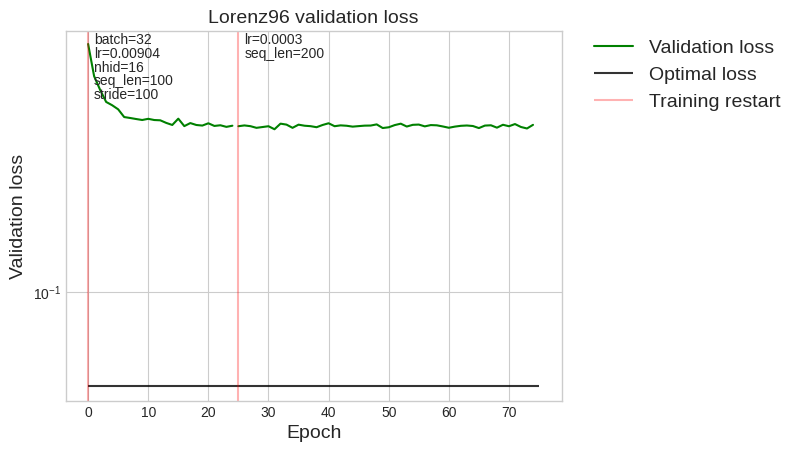

In [134]:
paths = ['models/lorenz96/0/', 'models/lorenz96/1/']
plot_training_routine(paths, "Lorenz96 validation loss")

We can see that the network doesn't converge correctly to the theoretical limit. We hypothesize that this is due to the higher complexity of the Lorenz96 system compared to the Lorenz63 one. Therefor, the network needs a higher number of hidden states to be able to do a good reconstruction. In the next runs, we increased the hidden states to 150 or 200.

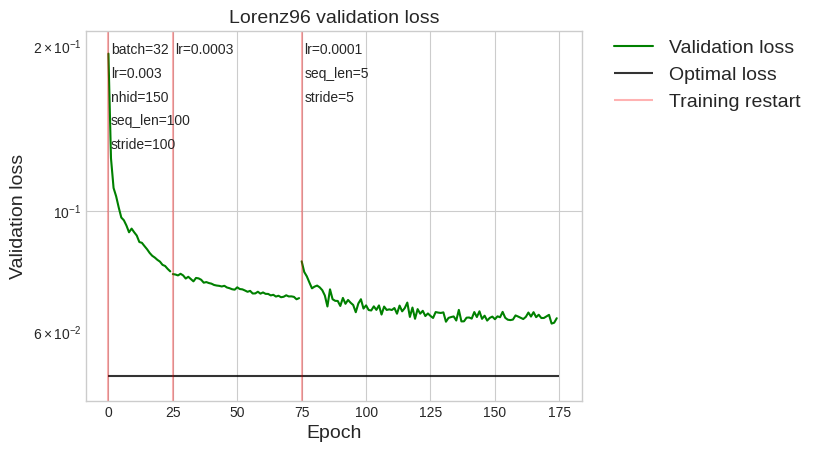

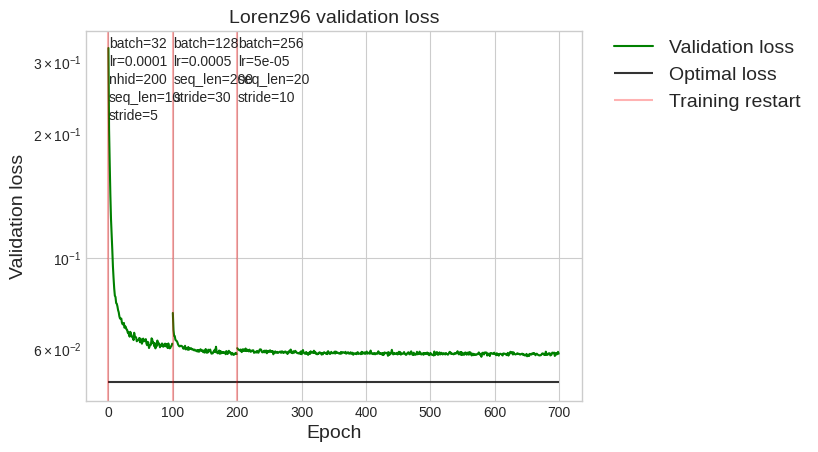

In [2]:
paths = ['models/lorenz96/5/', 'models/lorenz96/6/', 'models/lorenz96/7/']
plot_training_routine(paths, "Lorenz96 validation loss")
paths = ['models/lorenz96/8/', 'models/lorenz96/9/', 'models/lorenz96/10/']
plot_training_routine(paths, "Lorenz96 validation loss")

## Reconstruction and power-spectrum distance

For plotting a reconstruction, we use the models with hidden states=200 and a sequence length of 5 and 200 respectively. The inference time takes considerably longer since the model has an input and output size of 20 compared to 3 for the Lorenz63 system. We only plot the first three dimensions of the system.

Progress: 0/1000
Progress: 200/1000
Progress: 400/1000
Progress: 600/1000
Progress: 800/1000


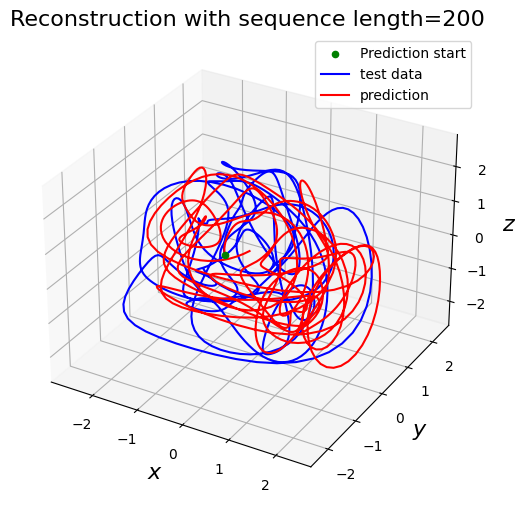

Progress: 0/1000
Progress: 200/1000
Progress: 400/1000
Progress: 600/1000
Progress: 800/1000


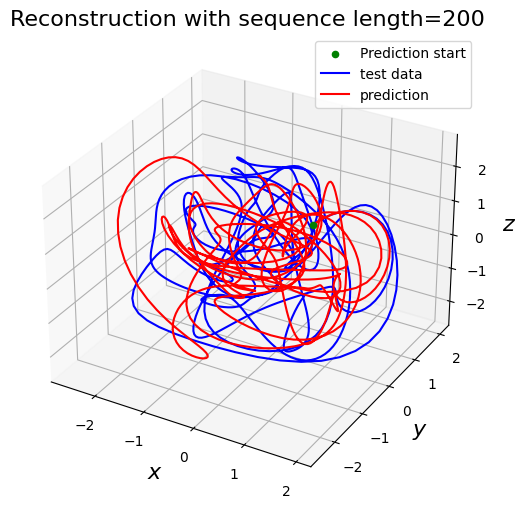

In [2]:
%run plot.py \
	--model_path="models/lorenz96/9/model.pt" \
	--lorenz_type="lorenz96" \
	--nhid=200 \
	--T=1000 \
	--bootstrapT=200 \
	--title="Reconstruction with sequence length=200"

%run plot.py \
	--model_path="models/lorenz96/10/model.pt" \
	--lorenz_type="lorenz96" \
	--nhid=200 \
	--T=1000 \
	--bootstrapT=5 \
	--title="Reconstruction with sequence length=200"

For the power-spectrum distance, we use the model trained on the sequence length of 5 since its much faster and we want to generate a time series of equal length to the test data.

Progress: 0/100010
Progress: 200/100010
Progress: 400/100010
Progress: 600/100010
Progress: 800/100010
Progress: 1000/100010
Progress: 1200/100010
Progress: 1400/100010
Progress: 1600/100010
Progress: 1800/100010
Progress: 2000/100010
Progress: 2200/100010
Progress: 2400/100010
Progress: 2600/100010
Progress: 2800/100010
Progress: 3000/100010
Progress: 3200/100010
Progress: 3400/100010
Progress: 3600/100010
Progress: 3800/100010
Progress: 4000/100010
Progress: 4200/100010
Progress: 4400/100010
Progress: 4600/100010
Progress: 4800/100010
Progress: 5000/100010
Progress: 5200/100010
Progress: 5400/100010
Progress: 5600/100010
Progress: 5800/100010
Progress: 6000/100010
Progress: 6200/100010
Progress: 6400/100010
Progress: 6600/100010
Progress: 6800/100010
Progress: 7000/100010
Progress: 7200/100010
Progress: 7400/100010
Progress: 7600/100010
Progress: 7800/100010
Progress: 8000/100010
Progress: 8200/100010
Progress: 8400/100010
Progress: 8600/100010
Progress: 8800/100010
Progress: 9000/10

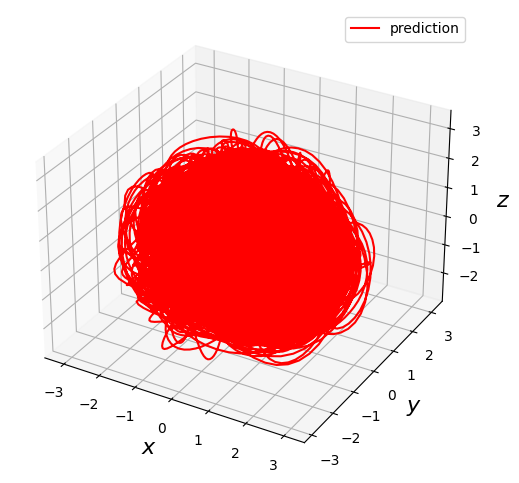

0.5816872518136956


In [2]:
%run psd_routine.py \
	--model_path="models/lorenz96/10/model.pt" \
	--nhid=200 \
	--T=100000 \
	--lorenz_type="lorenz96" \
    --bootstrapT=5

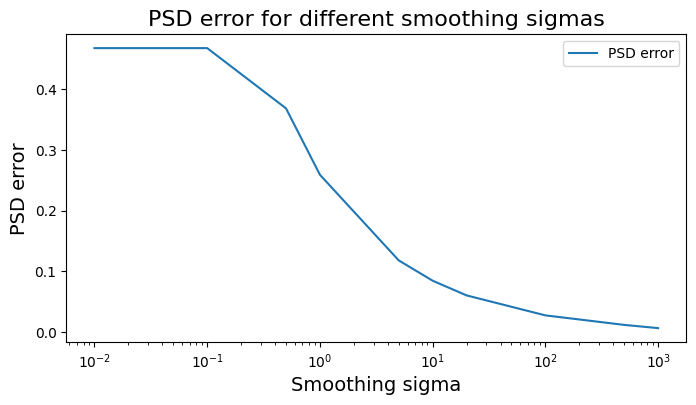

In [8]:
import psd
import numpy as np
import matplotlib.pyplot as plt

test_data = np.load('data/lorenz96_test.npy')
gen_data = np.load('data/lorenz96_gen.npy')

uniform_data = np.random.uniform(-1, 1, gen_data.shape)

sigmas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 100, 500, 1000]
psds = []

for sigma in sigmas:
	psd.SMOOTHING_SIGMA = sigma
	psds.append(psd.power_spectrum_error(test_data.reshape(1, -1, 20), gen_data.reshape(1, -1, 20)))

plt.figure(figsize=(8, 4))
plt.plot(sigmas, psds, label='PSD error')
plt.xlabel('Smoothing sigma', fontsize=14)
plt.ylabel('PSD error', fontsize=14)
plt.legend()
plt.xscale('log')
plt.title('PSD error for different smoothing sigmas', fontsize=16)
plt.show()

We observe the same behavior as for the Lorenz63 system.

# Conclusion

To conclude, we see that the LEM model is successfully able to reconstruct the Lorenz63 as well as the Lorenz96 dynamical system.

In addition to the experiments done here, one could also try the following:

* Use different metrics used in dynamical systems theory like the power-spectrum distance as an objective for model training
* Tuning all hyperparameters (learning rate, sequence length, number of hidden states, etc.) to get the best possible reconstruction
* Training on different noise levels
* Maybe smoothing the data before training could lead to an even better reconstruction
* Trying reconstruction of different dynamical systems to test the limits of the model
* Comparing to other models like LSTMs or GRUs although this was mostly already done in the paper by Rusch et al.